In [1]:
from pathlib import Path
from klimaatbestendige_netwerken.pyBIVAS_plot import pyBIVAS_plot as pyBIVAS
import logging
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import json

Loading of shapely/geopandas failed. Geometric functions will not work
Loading of geopandas/shapely failed. Geometric functions will not work


In [2]:
knelpunt_arcs = {
    
    'BR_Lobith': 9204, 
    'WA_Erlecom': 6332,
    'WA_Nijmegen': 6321,
    'WA_Ewijk': 7046,
    'WA_Ophemert': 8870,  # Corrected in v0.3
    'WA_St. Andries': 7362,
    'WA_Zaltbommel': 7265,
    
    'NRL_Arnhem': 6621,
    
    'MWK_Weurt': 6325,
    'ARK_Tiel': 1705,
    'TK_Eefde': 5771,
    
    'MA_Niftrik': 7391,
    'MA_Mook': 7526,
    
    'IJ_Velp': 6510,
    'IJ_Brummen': 5916,
    'IJ_Wilp': 5699,
    'IJ_Terwolde': 5476,
    'IJ_Wapenveld': 4567,
    'IJ_Zalk': 3855,
    
    'DL_Emmerich': 21116,
    'DL_Ruhrort': 20552,
    'DL_Kaub': 20249,
    
}
knelpunt_arcs_array = list(knelpunt_arcs.values())

In [3]:
inputdir = Path('input_files')

In [4]:
outputdir = Path('preprocessing_KBN_v0.5')
outputdir.mkdir(exist_ok=True)

BIVAS_results_folder = inputdir / 'BIVAS_results'

B = pyBIVAS(BIVAS_results_folder / 'Bivas_Run3 Q Q1800 T Ref_2014.db')
B.set_scenario(52)

In [5]:
# outputdir = Path('preprocessing_KBN_v0.5_WLO2050_hoog')
# outputdir.mkdir(exist_ok=True)

# BIVAS_results_folder = inputdir / 'BIVAS_results'

# B = pyBIVAS(BIVAS_results_folder / 'Bivas_Run3 Q Q1800 T WLO2050_Hoog.db')
# B.set_scenario(52)

In [6]:
B.network_arcs(outputfileshape=outputdir / 'arcs.json');

In [7]:
# Export locations
knelpunt_to_shape = B.arcs.loc[knelpunt_arcs_array][['geometry']]
knelpunt_to_shape['name'] = knelpunt_arcs.keys()
knelpunt_to_shape['geometry'] = B.arcs.geometry.apply(lambda x: x.centroid)
knelpunt_to_shape.to_json(outputdir / 'arcs_knelpunten.json', default_handler=str)

# knelpunt_to_shape['geometry'] = knelpunt_to_shape['geometry'].centroid
# knelpunt_to_shape.reset_index().to_file(outputdir / 'arcs_knelpunten.json', driver='GeoJSON')

## Get Trips from BIVAS

In [8]:
# get results for all trips
trips = B.routestatistics_advanced(group_by=['TripsID'])
trips.to_json(outputdir / 'trips.json')

In [9]:
# Get for each trip which knelpunten are passed (this takes approx. 1 hour to compute)
knelpunt_route = {}
for t_id in tqdm(trips.index):
    route_arcs = B.route_arcs(t_id)
    
    knelpunt_route[t_id] = np.isin(knelpunt_arcs_array, route_arcs.ArcID.to_list())
    
knelpunt_route = pd.DataFrame(knelpunt_route).T
knelpunt_route.columns = knelpunt_arcs.keys()

100%|█████████████████████████████████████████████████████████████████████████| 387684/387684 [36:01<00:00, 179.32it/s]


In [10]:
# Number of trips per route
temp = knelpunt_route.copy()
temp['nTrips'] = trips['NumberOfTrips']
count_combinations = temp.groupby(knelpunt_route.columns.to_list(), axis=0)['nTrips'].sum()
count_combinations.to_csv(outputdir / 'route_ntrips.csv')

In [56]:
trips.loc[(knelpunt_route['MA_Mook'] == True) & (knelpunt_route['WA_St. Andries'] == True)  & (knelpunt_route['DL_Emmerich'] == True) ].T.iloc[1:].drop(['Origin_X', 'Origin_Y', 'Destination_X', 'Destination_Y']).to_excel('Maas_DL_via_StAndries.xlsx')

In [11]:
# # Number of possible combinations
# total_number_combinations = 2 ** (len(knelpunt_arcs))
# total_number_combinations

# from itertools import chain, combinations

# def powerset(iterable):
#     "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
#     s = list(iterable)
#     return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

# # all possible combinations
# all_combinations = list(powerset(list(knelpunt_arcs.keys())))
# len(all_combinations)

In [12]:
# Get dictionary of trip_ids per unique route 

# Get for each combination of columns the indices with this combination
i_per_group = knelpunt_route.groupby(knelpunt_route.columns.to_list(), axis=0).indices

# Rename index from boolean to set of knelpunten
# Rename values from index to trip_id
i_per_group = {frozenset(knelpunt_route.columns[list(i)]): knelpunt_route.index[indices]  for i, indices in i_per_group.items()}

# Write to json, this file is not really used later on (first convert, than write)
with open(outputdir / 'route_tripid.json', 'w') as fout:
    simple_dict = {",".join(list(k)): list([int(l) for l in v]) for k, v in i_per_group.items()}
    json.dump(simple_dict, fout, indent=2)

# Show the results
# pd.Series({k: len(v) for k, v in i_per_group.items()}).sort_values()

## Create QH-relaties

In [13]:
# Read QH per knelpunt
waterscenario_folder = inputdir / 'Waterdepth_files' / 'KBN_waterscenario'

QH = {}
QQ = {}

for Q in [700, 850, 1020, 1400, 1800]:
    data = pd.read_csv(waterscenario_folder / f'waterscenario_15_Q{Q}.csv')
    data = data.set_index('ArcID').reindex(knelpunt_arcs_array)
    QH[Q] = data['WaterDepth__m']
    QQ[Q] = data['RateOfFlow__m3_s']
    
QH = pd.concat(QH, axis=1)
QH = QH.fillna(9)
QH.index = knelpunt_arcs.keys()

# QH.to_json(outputdir / 'knelpunt_discharge_waterdepth.json', orient='index', indent=2)

QQ = pd.concat(QQ, axis=1)
QQ.index = knelpunt_arcs.keys()
QQ = QQ.replace({0: np.nan})

# Fill nans with Lobith values
QQ = QQ.fillna({Q:Q for Q in QQ.columns})

# QQ.to_json(outputdir / 'knelpunt_discharge_waterdepth.json', orient='index', indent=2)


In [14]:
# Handmatige toevoegingen:

# From De Jong (2020). Digital Twin Waterways: Water levels and water depths on the river Rhine. Deltares memo 11205224-000-ZWS-0011, v1.0 d.d. 12 august 2020

## NOT GOOD. TOO MUCH ROUNDING!!

# additional_depth_functions = {
# 	'Kaub': lambda Q: 12.20 * Q**0.08 - 21.02 + -1.12,
# 	'Ruhrort': lambda Q: 0.07**0.58 - 1.47 + -0.47,
# 	'Emmerich': lambda Q: 0.10**0.53 - 3.28 + -1.96
# }

# Zelfde gegevens, maar dan al geexporteerd:
DTV_file = inputdir / 'Waterdepth_files' / 'DTV_regressions' / 'Depth.csv'
depth_DL = pd.read_csv(DTV_file, index_col=0)
depth_DL = depth_DL.rename(columns={'Duisburg-Ruhrort': 'Ruhrort'})

Q = QH.columns
for name in ['Kaub', 'Ruhrort', 'Emmerich']:
    QH.loc[f'DL_{name}'] = np.interp(Q, depth_DL.index, depth_DL[name])

In [15]:
# Zie tabel 2.2 van pot blootstelling Maas
QH.loc['MA_Niftrik'] = 3.2 * 1.4
QH.loc['MA_Mook']= 3 * 1.4 # eigenlijk pas na Venlo, tussen Venlo en Mook is de diepte nog 3.5

In [16]:
QH.loc['TK_Eefde'] += 2.3  # Original data was met de oude sluis (drempel op 0.0 m+NAP), terwijl de nieuwe sluis een drempel heeft op -2.3 m+NAP

In [17]:

# Manual create json
QH_json = {}
for k in QH.index:
    QH_json[k] = {np.round(Q, 0): np.round(H, 3) for Q, H in zip(QQ.loc[k].values, QH.loc[k].values)}

outputfile = outputdir / 'knelpunt_discharge_waterdepth.json'
with open(outputfile, 'w') as fout:
    fout.write(json.dumps(QH_json, indent=2))
# Test read function
# pd.read_json(outputdir / 'knelpunt_discharge_waterdepth.json')

## Get response functions

In [18]:
# VD-EUR per corridor

def costs(trips, depth):
    """
    Compute costs (and more) for list of trips if the depth is lower than :
    
      trips: output from pyBIVAS (routestatistics_advanced(group_by=['TripsID'])) or a subset of this data [DataFrame]
      depth: available (limited) waterdepth [float]
    
    returns: [float]
      effect: number of trips affected by limiting water depth
      effect: loss in tonnage due to limiting water depth
      effect: loss in potential tonnage due to limiting water depth (the tonnage at LoadCapacity)
      reaction: increase in number of trips due to limiting water depth
      reaction: increase in sailing costs due to limiting water depth
      reaction: trips_feasible, trips taking into account that trips are seized at 20%
      reaction: tonnage_feasible, tonnage taking into account that trips are seized at 20%
    
    """
    
    trips['Totale Vracht (ton) per trip'] = trips['Totale Vracht (ton)'] / trips['Aantal Vaarbewegingen (-)']
    
    # Decrease in load (0 to 100%)
    load_decrease = 1 - ((trips['Depth__m'] - depth) * 100 * trips['TPCMI']) / trips['Totale Vracht (ton) per trip']
    load_decrease.clip(lower=0, upper=1, inplace=True)  # Maximum realistic limits
    load_decrease.fillna(0, inplace=True)  # For empty vessels 

    # Effect: decrease in tonnage
    tonnage = load_decrease.clip(lower=0, upper=1) * trips_subset['Totale Vracht (ton)']
    
    # Effect: (does not work for empty ships!)
#     tonnage_potential = (load_decrease.clip(lower=0) * trips['Beladingsgraad']).clip(upper=1) * trips['LoadCapacity__t']
    
    beladingsgraad_potential = ((depth - trips['Ledige_diepgang']) / (trips['Maximale_diepgang'] - trips['Ledige_diepgang']))
    beladingsgraad_potential.clip(lower=0, upper=1, inplace=True)
    beladingsgraad_potential.fillna(0, inplace=True)  # Nans exist because of vessel with loadcapacity=0
    tonnage_potential = beladingsgraad_potential * trips['LoadCapacity__t'] * trips['Aantal Vaarbewegingen (-)']

    # Reaction: Minimal of 0.2 (so max 80% reduction), maximum of 1.0 (no change)
    load_decrease_clipped = load_decrease.clip(lower=0.2, upper=1)
    trips_increase = load_decrease_clipped ** -1
    
    # Reaction: increase in (variable) costs and number of trips
    costs_n = trips['Totale Vaste Vaarkosten (EUR)'] + trips['Totale Variabele Vaarkosten (EUR)'] * trips_increase
    trips_n = trips['Aantal Vaarbewegingen (-)'] * trips_increase  # This is only necessary if in the original data the trips != 1
    
    # Assuming that at 20% beladingsgraad the trips drop to 0
    trips_feasible = trips_n * (load_decrease_clipped != 0.2)
    tonnage_feasible = trips_subset['Totale Vracht (ton)'] * (load_decrease_clipped != 0.2)
    
    response = pd.DataFrame(
        index = trips.index,
        data = {
            'trips_affected': ((trips['Depth__m'] > depth) * trips['Aantal Vaarbewegingen (-)']),
            'tonnage' : tonnage,
            'tonnage_potential' : tonnage_potential,
            'costs' : costs_n,
            'trips' : trips_n,
            'trips_feasible': trips_feasible,
            'tonnage_feasible': tonnage_feasible,
#             'beladingsgraad_potential_relative': load_decrease,
#             'beladingsgraad_potential_absolute': beladingsgraad_potential,
        }
    )
    
#     response_total = response.sum()
    return response

In [19]:
# For each route, get effect of a lowering waterdepth based on all ships passing on this (unique) route
all_depths = np.linspace(0, 10, 101)
all_depths = np.round(all_depths, 2)

effect_and_reaction = {}

for ks, tripids in tqdm(i_per_group.items()):
    
    # Get all trips on route in the full year
    trips_subset = trips.reindex(tripids)
    
    # Compute effect on tonnage and reaction in trips and costs
    effect_and_reaction[ks] = pd.DataFrame(
        data=[costs(trips_subset,  depth).sum() for depth in all_depths], 
        index=all_depths,
    )
    
effect_and_reaction = pd.concat(effect_and_reaction, axis=1).T.swaplevel(axis=0).sort_index()

# Convert to per day
effect_and_reaction = effect_and_reaction / 365

# Export for use in model
params = effect_and_reaction.index.levels[0]
for param in params:
    exportdata = effect_and_reaction.loc[param]
    exportdata.index = ['{' + ', '.join(i) + '}' for i in exportdata.index]
    exportdata.to_json(outputdir / f'route_depth_{param}.json', double_precision=2, indent=2, orient='index')

    
# Export for interpretation
writer = pd.ExcelWriter(outputdir / 'route_depth_functions.xlsx',)
for param in params:
    exportdata = effect_and_reaction.loc[param]
    exportdata.index.name = 'Route'
    exportdata.columns.name = 'Depth'
    exportdata.T.to_excel(writer, sheet_name=param)
writer.save()    
writer.close()

100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [02:16<00:00,  1.56it/s]


In [20]:
# # Snippit for importing
# routes_depth_costs = pd.read_json(outputdir / f'route_depth_{param}.json', convert_dates=False, convert_axes=False)
# routes_depth_costs.columns = [frozenset(i[1:-1].split(',')) for i in routes_depth_costs.columns]
# routes_depth_costs.index = [float(c) for c in routes_depth_costs.index]

In [21]:
# # Same but with additional subgroups. Not using this output yet anywhere...
# # For each route, get effect of a lowering waterdepth based on all ships passing on this (unique) route
# all_depths = np.linspace(0, 10, 101)
# all_depths = np.round(all_depths, 2)

# effect_and_reaction_subgroups = {}
# groups = ['Origin_Zone', 'Destination_Zone', 'Vorm']

# for ks, tripids in i_per_group.items():
    
#     # Get all trips on route in the full year
#     trips_subset = trips.reindex(tripids)
    
#     groupby_subset = trips_subset.groupby(groups)

#     # Compute effect on tonnage and reaction in trips and costs
#     route_effect_and_reaction = {}
#     for depth in tqdm(all_depths):
#         response = costs(trips_subset,  depth)

#         response_grouped = {}
#         for k, i in groupby_subset.indices.items():
#             id = trips_subset.index[i]
#             response_grouped[k] = response.reindex(id, axis=0).sum()
#         response_grouped = pd.concat(response_grouped, axis=0)
#         route_effect_and_reaction[depth] = response_grouped
#     route_effect_and_reaction = pd.concat(route_effect_and_reaction, axis=0).unstack(level=0).T
    
#     effect_and_reaction_subgroups[ks] = route_effect_and_reaction

# effect_and_reaction_subgroups = pd.concat(effect_and_reaction_subgroups, axis=1)

# # Convert to per day
# effect_and_reaction_subgroups = effect_and_reaction_subgroups / 365

# # Export totalcosts for use in model
# totalcosts_subgroups = effect_and_reaction_subgroups.xs('costs', axis=1, level=-1)
# totalcosts_subgroups.reset_index().rename(columns={'index': 'routes'}).to_json(outputdir / 'route_depth_costs_subgroups.json', double_precision=2)

# End of model pre-processing

# Some postprocessing and plots

Text(0, 0.5, 'Waterdiepte (m)')

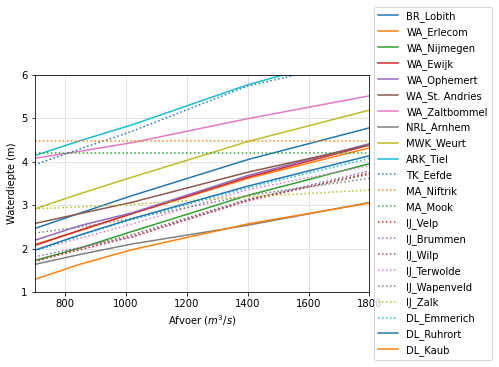

In [22]:
# Plot QH
styles = ['-'] * 10 +  [':'] * 10 
QH.T.plot(style=styles)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.grid(c='#DDD')
plt.autoscale('x', tight=True)
plt.ylim(1, 6)
plt.xlabel('Afvoer ($m^3/s$)')
plt.ylabel('Waterdiepte (m)')
# plt.savefig(outputdir / 'knelpunt_discharge_waterdepth.png', dpi=300, bbox_inches='tight')

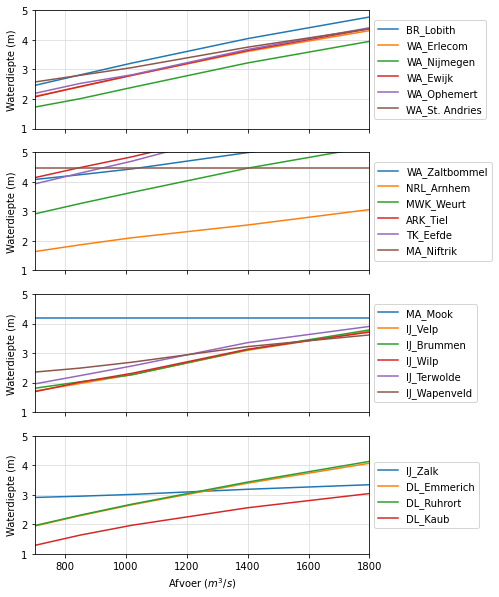

In [23]:
# Plot QH
f, ax = plt.subplots(nrows=4, figsize=(6, 10), sharey=True, sharex=True)
ii = 0
for a in ax:
    plt.sca(a)
    QH.T.iloc[:, ii:ii+6].plot(style=styles, ax=a)
    
    ii += 6
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
    plt.grid(c='#DDD')
    plt.ylabel('Waterdiepte (m)')
plt.autoscale('x', tight=True)
plt.ylim(1, 5)
plt.xlabel('Afvoer ($m^3/s$)')
plt.savefig(outputdir / 'knelpunt_discharge_waterdepth_grid.png', dpi=300, bbox_inches='tight')

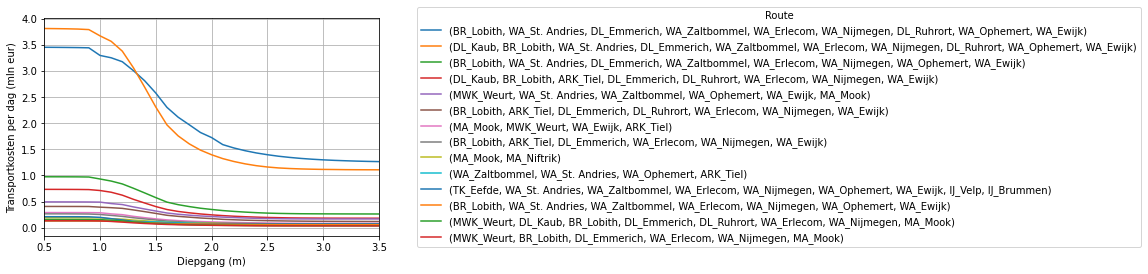

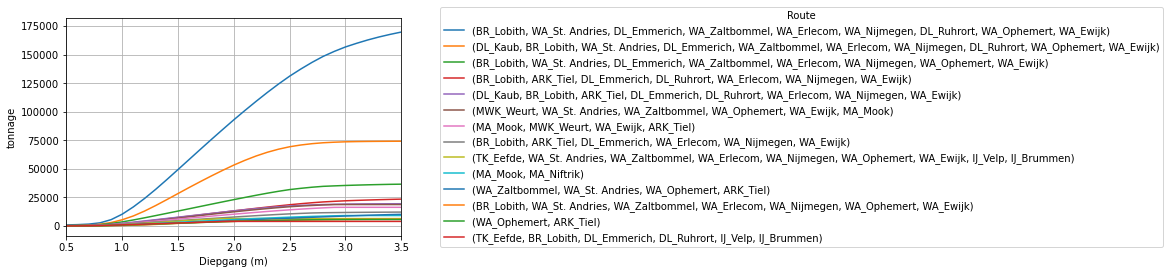

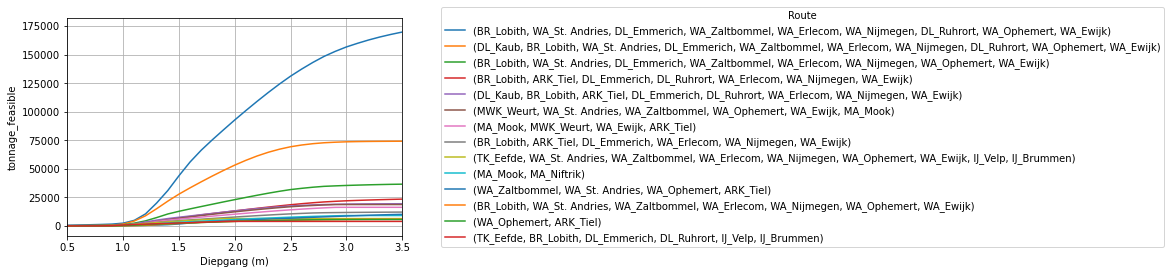

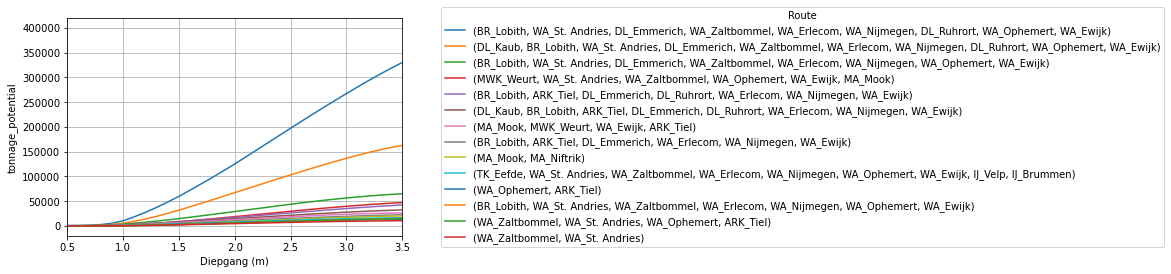

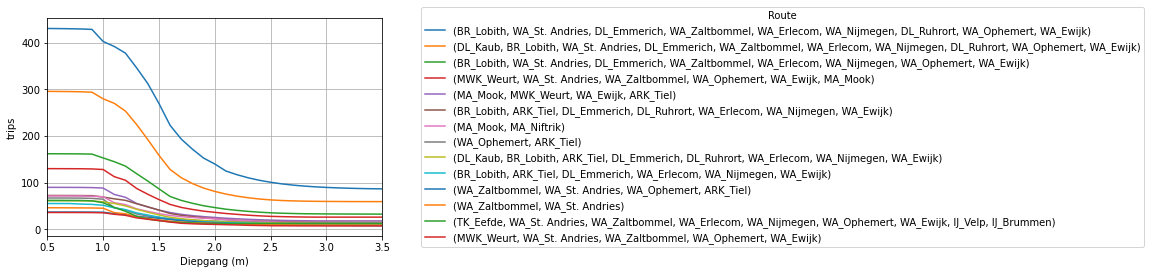

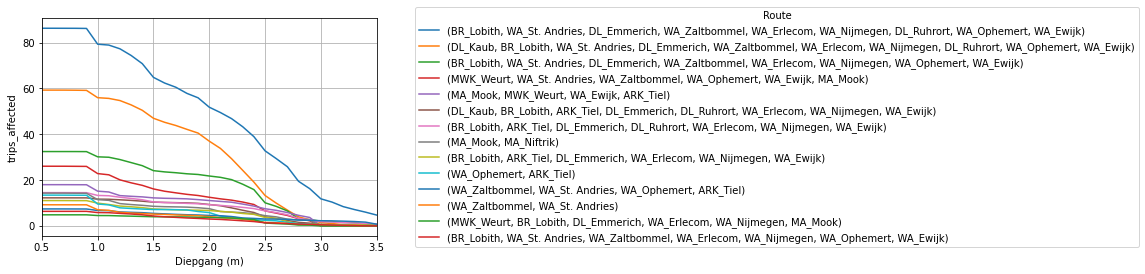

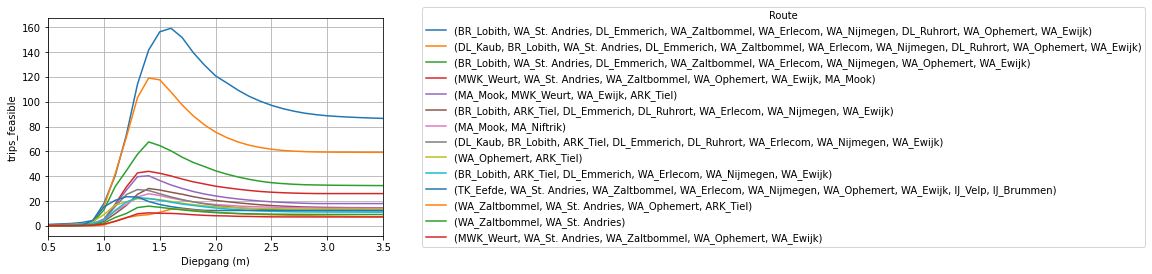

In [24]:
# Plot effect of reducing depth per route
params = effect_and_reaction.index.levels[0]
for p in params:
    totalcosts = effect_and_reaction.loc[p]

    
    if p == 'costs':
        (totalcosts.sort_values(2.0, axis=0, ascending=False).T / 1e6).iloc[:, 1:15].plot()
        plt.ylabel('Transportkosten per dag (mln eur)')
    else:
        (totalcosts.sort_values(2.0, axis=0, ascending=False).T / 1e0).iloc[:, 1:15].plot()
        plt.ylabel(p)
    plt.xlabel('Diepgang (m)')
    plt.xlim(0.5, 3.5)
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1.1,0.5), title='Route')

    plt.savefig(outputdir / f'route_depth_{p}.png', dpi=300, bbox_inches='tight')

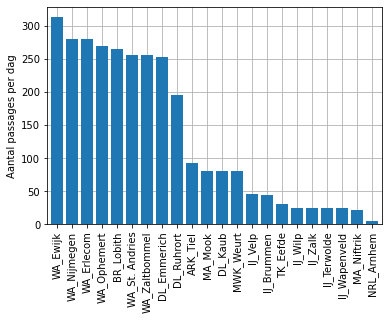

In [25]:
# Should multiply by nTrips
plotdata = (knelpunt_route.sum() / 365).sort_values(ascending=False)
plotdata.plot.bar(width=0.8, zorder=3)
plt.ylabel('Aantal passages per dag')
plt.grid()
plt.savefig(outputdir / 'knelpunten_passages_per_dag.png', dpi=300, bbox_inches='tight')
plotdata.to_csv(outputdir / 'knelpunten_passages_per_dag.csv')

## Influence per knelpunt

In [26]:
def reindex_and_interpolate(df, new_index):
    return df.reindex(df.index | new_index).interpolate(method='index', limit_direction='both').loc[new_index]

In [27]:
alltrips_sum = {}
mintrips_sum = {}

# Loop over all knelpunten
for k in tqdm(knelpunt_arcs.keys()):

    # Get all routes which pass the knelpunt
    ii_routes_with_k = [k in totalcosts.index[ii] for ii in range(totalcosts.shape[0])]
    routes_with_k = totalcosts.index[ii_routes_with_k]


    # For each route, compute the number of influenced trip at each depth (both: all trips, and trips where this knelpunt is limiting)
    alltrips = {}
    mintrips = {}

    # For each route
    for r in routes_with_k:

        # Get QH for all knelpunten on route
        r_QH = QH.loc[r].T

        # Convert to relation depth_k-depth_other_k 
        r_HH = r_QH.copy()
        r_HH.index = r_HH.loc[:, k]
        r_HH = r_HH[~r_HH.index.duplicated(keep='first')]  # On duplicate index (=depth) only keep first
        r_HH = reindex_and_interpolate(r_HH, all_depths)  # Reindex to range
        

        # Get index of all depths where k is minimal
        k_minimal = r_HH.idxmin(axis=1) == k

        # Get number of affected trips (per waterdepth)
        alltrips[r] = effect_and_reaction.xs(r, axis=0, level=1)
        mintrips[r] = alltrips[r].loc[:, k_minimal].reindex(all_depths, axis=1).fillna(0)

    alltrips = pd.concat(alltrips, axis=1).T
    mintrips = pd.concat(mintrips, axis=1).T
    
    # Sum over all routes passing given knelpunt, resulting in DataFrame(index=depth, columns=[trips affected, etc.])
    alltrips_sum[k] = alltrips.sum(axis=0, level=1)
    mintrips_sum[k] = mintrips.sum(axis=0, level=1)

alltrips_sum = pd.concat(alltrips_sum, axis=1).swaplevel(axis=1).sort_index(axis=1)
mintrips_sum = pd.concat(mintrips_sum, axis=1).swaplevel(axis=1).sort_index(axis=1)

  0%|                                                                                           | 0/22 [00:00<?, ?it/s]<ipython-input-26-44f171324dea>:2: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  return df.reindex(df.index | new_index).interpolate(method='index', limit_direction='both').loc[new_index]
100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:04<00:00,  4.75it/s]


In [29]:
# Validation, should be 0
trips['Aantal Vaarbewegingen (-)'].sum() - effect_and_reaction.loc['trips_affected'].iloc[0, 0]*365 - mintrips_sum['trips_affected'].sum(axis=1).iloc[0]*365

-8.731149137020111e-11

In [30]:
# Number of trips per route
# effect_and_reaction.loc['trips', 10].sort_values(ascending=False)

# Number of tirps per knelpunt
# alltrips_sum['trips'].loc[10]

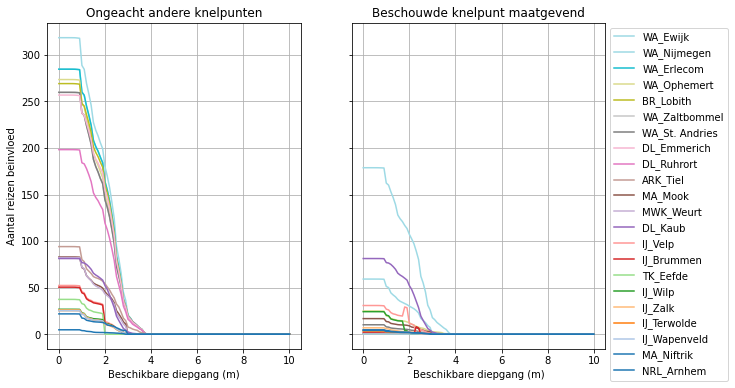

In [33]:
f, ax = plt.subplots(ncols=2, figsize=(10, 6), sharey=True)
plt.sca(ax[0])
plotdata = alltrips_sum.sort_values(axis=1, by=0, ascending=False)['trips_affected']
plotdata.plot(cmap='tab20_r', legend=False, ax=ax[0])
plt.grid()
# plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Beschikbare diepgang (m)')
plt.ylabel('Aantal reizen beinvloed')
plt.title('Ongeacht andere knelpunten')

plt.sca(ax[1])
mintrips_sum['trips_affected'][plotdata.columns].plot(cmap='tab20_r', ax=ax[1])
plt.grid()
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Beschikbare diepgang (m)')
plt.ylabel('Aantal reizen beinvloed')
plt.title('Beschouwde knelpunt maatgevend')
# plt.ylim(top=10000)

plt.savefig(outputdir / 'Effect_knelpunten.png', dpi=300, bbox_inches='tight')

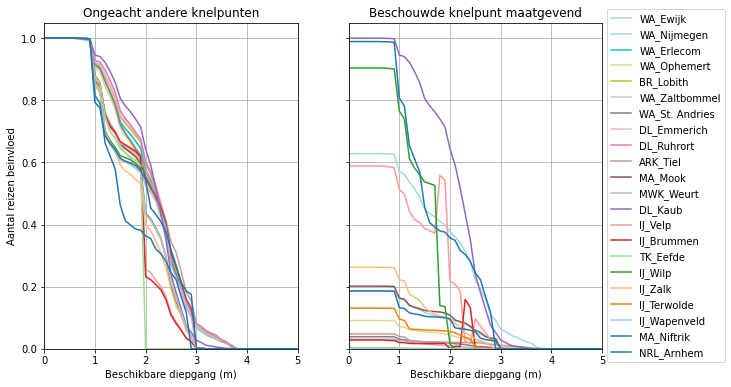

In [35]:
f, ax = plt.subplots(ncols=2, figsize=(10, 6), sharey=True, sharex=True)
plt.ylim(0,1.05)
plt.xlim(0, 5)
plt.sca(ax[0])
plotdata = alltrips_sum.sort_values(axis=1, by=0, ascending=False)['trips_affected']
maxtrips = plotdata.loc[0]
plotdata_normed = plotdata / maxtrips
# Normalise 
plotdata_normed.plot(cmap='tab20_r', legend=False, ax=ax[0])
plt.grid()
# plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Beschikbare diepgang (m)')
plt.ylabel('Aantal reizen beinvloed')
plt.title('Ongeacht andere knelpunten')

plt.sca(ax[1])
plotdata2 = mintrips_sum['trips_affected'][plotdata.columns] / maxtrips
plotdata2.plot(cmap='tab20_r', ax=ax[1])
plt.grid()
plt.legend(bbox_to_anchor=(1,0.5), loc='center left')
plt.xlabel('Beschikbare diepgang (m)')
plt.ylabel('Aantal reizen beinvloed')
plt.title('Beschouwde knelpunt maatgevend')

plt.savefig(outputdir / 'Effect_knelpunten.png', dpi=300, bbox_inches='tight')

<ipython-input-38-a1d883da7b3e>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]);


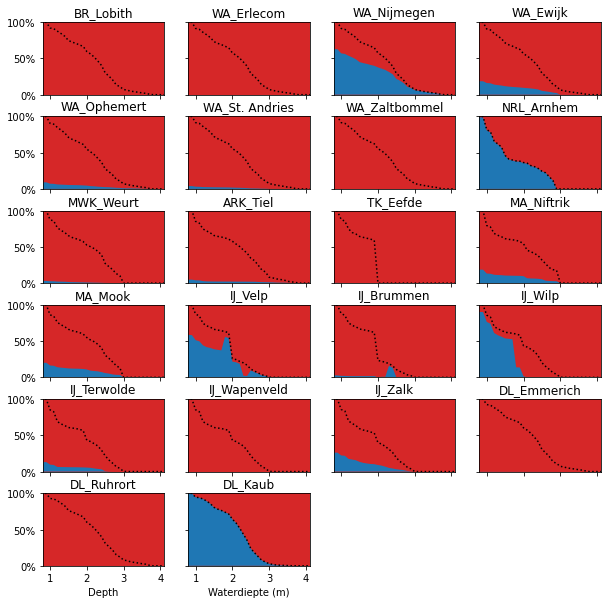

In [38]:
plotdata = alltrips_sum.sort_values(axis=1, by=0, ascending=False)['trips_affected']
maxtrips = plotdata.loc[0]
plotdata_normed = plotdata / maxtrips
plotdata2 = mintrips_sum['trips_affected'][plotdata.columns]
plotdata2_normed = plotdata2 / maxtrips


f, ax = plt.subplots(6, 4, sharex=True, sharey=True, figsize=(10,10))
plt.subplots_adjust(hspace=0.3)

ax = ax.flatten()

for ii, name in enumerate(QH.index):
    data = plotdata2_normed[name]
    plt.sca(ax[ii])
    plt.title(name)
    plt.fill_between(data.index, data.values)
    plt.annotate('{:.1f}'.format(maxtrips[name]), (0.1, 0.05), color='w')
    ax[ii].set_facecolor('C3')
    plotdata_normed[name].plot(ax=ax[ii], ls=':', c='k')
plt.xlim(0.8, 4.1)
plt.ylim(0, 1)

plt.xlabel(f'Waterdiepte (m)')

ax[ii+1].set_axis_off()
ax[ii+2].set_axis_off()

plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]);

plt.savefig(outputdir / 'Knelpunten_perc_reizen_beinvloed_WL.png', dpi=300, bbox_inches='tight')

## Similar analyses, now per discharge

In [39]:
# This function computes for different discharges: (1) what are the [params] if all ships passing a knelpunt are effected. 

alltrips_sum = {}
mintrips_sum = {}

def interp(df, new_index):
    """Return a new DataFrame with all columns values interpolated
    to the new_index values."""
    df_out = pd.DataFrame(index=new_index)
    df_out.index.name = df.index.name

    for colname, col in df.iteritems():
        df_out[colname] = np.interp(new_index, df.index, col)

    return df_out

alltrips = {}
mintrips = {}
routes = totalcosts.index

route_costs_Q = {}

ukc=0.2

for r in routes:
    # Get depth at all knelpunten on route
    r_QH = QH.loc[r].T
    
    # Get the depth-costs relation for this route
    response_on_route = effect_and_reaction.xs(r, axis=0, level=1)
    
    # Get total costs on this route
    min_depth_on_route = r_QH.min(axis=1).fillna(999)  # FIllna for route ()
    min_depth_on_route -= ukc

    route_costs_Q[r] = interp(response_on_route.T, min_depth_on_route.values)
    route_costs_Q[r].index = r_QH.index
    route_costs_Q[r]['costs_increase'] = route_costs_Q[r]['costs'] - route_costs_Q[r]['costs'][1800]
    
    for k in r:
        # Get number of affected trips (per waterdepth)
        depth_at_k = r_QH[k].values - ukc
        
        # Interpolate costs to discharge levels
        alltrips[(r, k)] = interp(response_on_route.T, depth_at_k)
        alltrips[(r, k)].index = r_QH.index
        alltrips[(r, k)]['costs_increase'] = alltrips[(r, k)]['costs'] - alltrips[(r, k)]['costs'][1800]

        # Only select those levels where k is the minimum depth on the route
        k_minimal = r_QH.idxmin(axis=1) == k
        mintrips[(r, k)] = route_costs_Q[r].mul(k_minimal, axis=0)

alltrips = pd.concat(alltrips)        
mintrips = pd.concat(mintrips)
route_costs_Q = pd.concat(route_costs_Q, axis=1)

alltrips_sum = alltrips.unstack(level=1).sum(axis=0, level=1)
mintrips_sum = mintrips.unstack(level=1).sum(axis=0, level=1)



<ipython-input-41-d5c1173baf6d>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]);


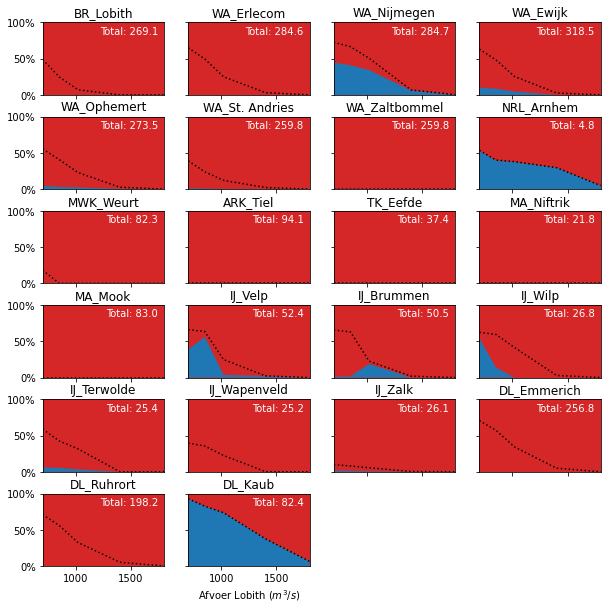

In [41]:
# If no other knelpunten exists:
plotdata = alltrips_sum['trips_affected']
maxtrips = alltrips_sum['trips'].loc[1800]
plotdata_normed = plotdata / maxtrips

# Taking into account other knelpunten
plotdata2 = mintrips_sum['trips_affected'][plotdata.columns]
plotdata2_normed = plotdata2 / maxtrips


f, ax = plt.subplots(6, 4, sharex=True, sharey=True, figsize=(10,10))
plt.subplots_adjust(hspace=0.3)
ax = ax.flatten()

for ii, name in enumerate(QH.index):
    data = plotdata2_normed[name]
    plt.sca(ax[ii])
    plt.title(name)
    plt.fill_between(data.index, data.values)
    plt.annotate('Total: {:.1f}'.format(maxtrips[name]), (0.95, 0.95), color='w', xycoords='axes fraction', ha='right', va='top')
    ax[ii].set_facecolor('C3')
    plotdata_normed[name].plot(ax=ax[ii], ls=':', c='k')
plt.xlim(plotdata2.index[0], plotdata2.index[-1])
plt.ylim(0, 1)
plt.xlabel(f'Afvoer Lobith ($m^3/s$)')

ax[ii+1].set_axis_off()
ax[ii+2].set_axis_off()

plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]);

plt.savefig(outputdir / 'Knelpunten_perc_reizen_beinvloed_Q.png', dpi=300, bbox_inches='tight')

In [42]:

def inverselegend(outside=False, **kwargs):
    if outside:
        return plt.gca().legend(*map(reversed, plt.gca().get_legend_handles_labels()), loc='center left',
                         bbox_to_anchor=(1, 0.5), **kwargs)
    else:
        return plt.gca().legend(*map(reversed, plt.gca().get_legend_handles_labels()), **kwargs)

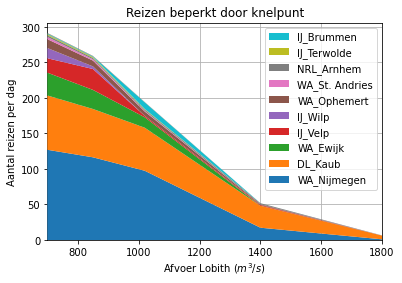

In [43]:
plotdata2 = mintrips_sum['trips_affected'][plotdata.columns]
plotdata2= plotdata2.sort_values(axis=1, by=700, ascending=False)
pc = plt.stackplot(plotdata2.index, plotdata2.T, labels=plotdata2.columns[:10], zorder=3)
plt.legend(plotdata2.columns[:10])
plt.grid()
plt.xlim(plotdata2.index[0], plotdata2.index[-1])
inverselegend()
plt.xlabel(f'Afvoer Lobith ($m^3/s$)')
plt.ylabel('Aantal reizen per dag')
plt.title('Reizen beperkt door knelpunt')

plt.savefig(outputdir / 'Knelpunten_cum_reizen.png', dpi=300, bbox_inches='tight')

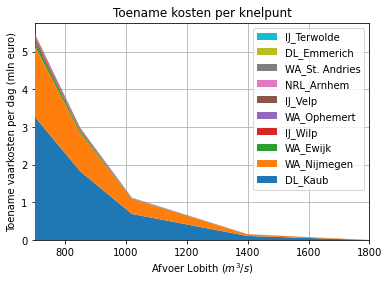

In [44]:
plotdata2 = mintrips_sum['costs_increase'].fillna(0)
plotdata2= plotdata2 / 1e6
plotdata2 = plotdata2.sort_values(axis=1, by=700, ascending=False)

pc = plt.stackplot(plotdata2.index, plotdata2.T[:10], labels=plotdata2.columns[:10], zorder=3)
plt.legend(plotdata2.columns)
plt.grid()
plt.xlim(plotdata2.index[0], plotdata2.index[-1])
inverselegend()
plt.xlabel(f'Afvoer Lobith ($m^3/s$)')
plt.ylabel('Toename vaarkosten per dag (mln euro)')
plt.title('Toename kosten per knelpunt')

plt.savefig(outputdir / 'Knelpunten_cum_costs.png', dpi=300, bbox_inches='tight')